In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

import glob

In [ ]:
image_directory = '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/'
mask_directory = '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/groundtruth/'

In [ ]:
SIZE = 256
num_images = 50

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/*.jpg")
print(image_names)

['/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx7.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx11.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx4.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx29.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx21.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx46.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx28.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx34.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx26.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx16.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx40.jpg', '/content/d

In [ ]:
image_names.sort()
print(image_names)

['/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx1.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx10.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx11.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx12.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx13.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx14.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx15.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx16.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx17.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx18.jpg', '/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/data/imgx19.jpg', '/content/

In [ ]:
image_names_subset = image_names[0:num_images]

In [ ]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [ ]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/Lecture/LAB/DAY 2/Semantic Segmentation/dataset/groundtruth/*.jpg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
#print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (50, 192, 256, 1)
Mask data shape is:  (50, 192, 256, 1)
Max pixel value in image is:  255


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

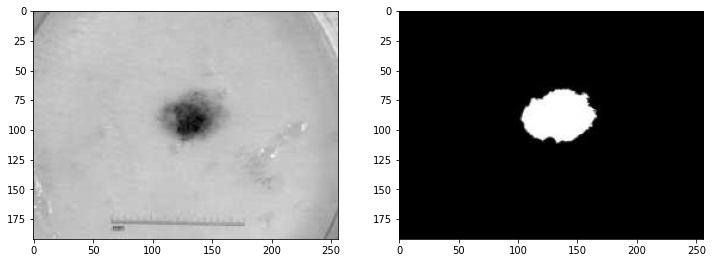

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [23]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/25
3/3 [==============================] - 216s 64s/step - loss: 0.5697 - accuracy: 0.6778 - val_loss: 0.6678 - val_accuracy: 0.7765
Epoch 2/25
3/3 [==============================] - 188s 59s/step - loss: 0.5020 - accuracy: 0.7264 - val_loss: 0.6403 - val_accuracy: 0.7765
Epoch 3/25
3/3 [==============================] - 184s 58s/step - loss: 0.4696 - accuracy: 0.7413 - val_loss: 0.6372 - val_accuracy: 0.7765
Epoch 4/25
3/3 [==============================] - 184s 58s/step - loss: 0.4509 - accuracy: 0.7466 - val_loss: 0.6250 - val_accuracy: 0.7765
Epoch 5/25
3/3 [==============================] - 183s 57s/step - loss: 0.4249 - accuracy: 0.7635 - val_loss: 0.6220 - val_accuracy: 0.7765
Epoch 6/25
3/3 [==============================] - 181s 57s/step - loss: 0.4116 - accuracy: 0.7805 - val_loss: 3.0203 - val_accuracy: 0.7765
Epoch 7/25
3/3 [==============================] - 186s 58s/step - loss: 0.4015 - accuracy: 0.7878 - val_loss: 2.8877 - val_accuracy: 0.7743
Epoch 8/25
3/3 [====

In [24]:
#Save the model for future use
model.save('25epochs.hdf5')

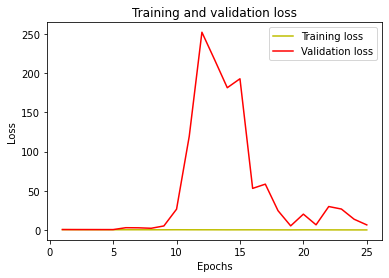

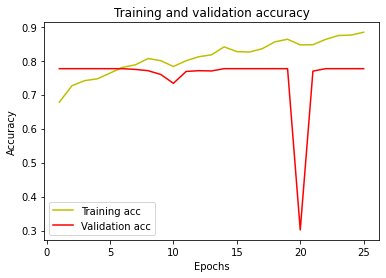

In [25]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
#Load previously saved model
from keras.models import load_model
model = load_model("25epochs.hdf5", compile=False)

In [27]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [28]:
from tensorflow.keras.metrics import MeanIoU

In [29]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.4176646


(1, 192, 256, 1)
(192, 256)


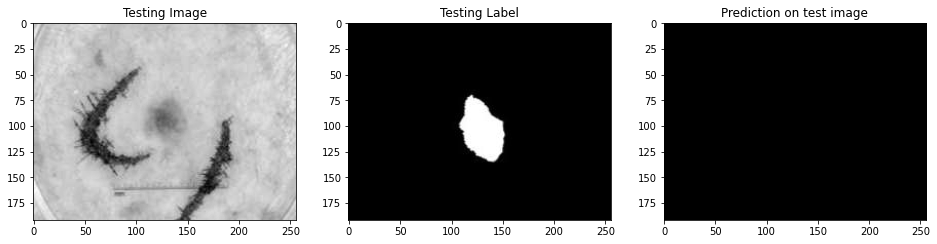

In [32]:
threshold = 0.5
test_img_number = random.randint(0, len(X_train)-1)
test_img = X_train[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()